
# Beadandó feladat!

## Deep Learning 2003 beadandó feladat!

#### Készítsen az alábbiakban letölthető fájlok segítségével egy a röntgen felvételeket értékelő bináris osztályozót. A felvételeken egészséges és beteg emberekhez tartozó röntgen képek találhatóak. A feladatot konvolúciós neurális hálózat segítségével valósítsa meg! Használjon korai leállítást, értékelje a modellt annak a pontosságával! Rajzolja ki a költségfügvény alakaulását (Loss) és szövegesen értékelje ki! Az elkészült modellt mentse el. A test adatokon értékelje a modelljét! A legjobb eredményt folyamatosan megosztom a Teamsben.

#### Beküldési határidő: 2023.december 22.


### Legeslegelőször beinportáljuk a szükséges könyvtárakat.

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import layers, applications
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import gdown
import zipfile
import os

2023-12-21 18:21:56.174195: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-21 18:21:56.174227: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-21 18:21:56.175436: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-21 18:21:56.182229: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-21 18:21:56.874750: W tensorflow/compiler/tf2

#### Majd letöltjük és kicsomagoljuk az adathalmazt.

In [2]:
# A Google Drive-os fájl letöltése
file_id = '1FfgdLCOpDlJZLp0MGohTh1sf4LgHICrN'
url = f'https://drive.google.com/uc?id={file_id}'
output = 'DL_beadandó.zip'
gdown.download(url, output, quiet=False)

# Fájl kicsomagolása
output_folder = 'XRAY'
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall(output_folder)
    
# Eredeti ZIP-fájl törlése
os.remove(output)

Downloading...
From (uriginal): https://drive.google.com/uc?id=1FfgdLCOpDlJZLp0MGohTh1sf4LgHICrN
From (redirected): https://drive.google.com/uc?id=1FfgdLCOpDlJZLp0MGohTh1sf4LgHICrN&confirm=t&uuid=9cd8a302-ddb8-422c-bd2d-0c83c6ab0514
To: /home/kmark7/teszt/DL_beadandó.zip
100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 412M/412M [00:20<00:00, 20.1MB/s]


#### Képek méretét és batch méretet rakjuk bele egy-egy "fő" változóba.

In [3]:
IMAGE_SHAPE = (250, 250)
BATCH_SIZE = 10

#### Kialakítjük az adathalmaz struktúráját.

In [4]:
# Adatok elérési útvonalai
train_dir = "XRAY/train/"
test_dir = "XRAY/test/"

# Kép adatgenerátorok létrehozása
train_datagen = ImageDataGenerator(rescale=1 / 255.)
test_datagen = ImageDataGenerator(rescale=1 / 255.)

# Tanító adathalmaz betöltése
print("Training images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

# Teszt adathalmaz betöltése
print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Training images:
Found 1000 images belonging to 2 classes.
Testing images:
Found 624 images belonging to 2 classes.


### Maga a CNN architektúráját látjuk itt.
#### Használunk BatchNormalizálást és Dropout-okat is: először konvolúciós rétegeket használunk, majd ezeket lapítjuk ki.
#### A konvolúciós rétegek kernelét kcsire (2*2-re) állítottam, a bemeneti képek 250*250 px felbontásúak.

In [5]:
# Konvolúciós neurális hálózat létrehozása
model = tf.keras.models.Sequential([
    layers.Conv2D(256, (2, 2), activation='relu', input_shape=(250, 250, 3)),
    layers.BatchNormalization(momentum=0.9),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (2, 2), activation='relu'),
    layers.BatchNormalization(momentum=0.9),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(16, (2, 2), activation='relu'),
    layers.BatchNormalization(momentum=0.9),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.25),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.9),
    layers.Dense(2, activation='softmax')
])

# Modell adatainak kiíratása
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 249, 249, 256)     3328      
                                                                 
 batch_normalization (Batch  (None, 249, 249, 256)     1024      
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 124, 124, 256)     0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 123, 123, 64)      65600     
                                                                 
 batch_normalization_1 (Bat  (None, 123, 123, 64)      256       
 chNormalization)                                                
                                                        

2023-12-21 18:24:49.935517: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-21 18:24:49.965236: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-21 18:24:49.965427: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

#### Excel fájlba logolunk, mivel később ott rekonstruálni tudjuk a tanulási görbéket, grafikonokat, és ezeken kívül egyéb statisztikákat is készíthetünk.

In [6]:
csv_logger = CSVLogger('ModelLog.csv', separator=',', append=False)

#### Beállítjuk az optimalizálót és a model aktivációs függvényét, tanulási rátáját.

In [7]:
initial_learning_rate = 0.00001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=5000, decay_rate=0.9, staircase=True)

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.AdamW(learning_rate=lr_schedule),
              metrics=['accuracy'])

### Bővítjük az adathalmazt.

In [8]:
# Bővített adathalmaz generátor létrehozása
train_datagen_augmented = ImageDataGenerator(
    rescale=1 / 255.,
    rotation_range=40,
    shear_range=0.3,
    zoom_range=0.1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Bővített tanító adathalmaz generálása
augmented_train_data = train_datagen_augmented.flow_from_directory(
    train_dir,
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

# Tanító adathalmazok összekapcsolása
combined_train_data = tf.data.Dataset.from_generator(
    lambda: train_data,
    output_signature=(
        tf.TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 2), dtype=tf.float32)
    )
).concatenate(
    tf.data.Dataset.from_generator(
        lambda: augmented_train_data,
        output_signature=(
            tf.TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 2), dtype=tf.float32)
        )
    )
)

Found 1000 images belonging to 2 classes.


#### Elmentünk egy tanítatlan modelt, erre majd a késöbbiekben lesz szükségünk.

In [9]:
model.save("PheoModel.h5")

/home/kmark7/pysorflow/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Korai leállítást és modell mentés callback-eket inicializáljuk.
#### Ez early stopping helyett ModelCheckpoint-ot használunk: minden epoch után ideiglenesen elmentjük, és a végén az adott szempont szerint legjobb modelt mentjük el véglegesen.

In [10]:
# Korai leállítás
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=5,
                               restore_best_weights=True,
                               verbose=1)

# Modell mentés callback-ek inicializálása
model_checkpoint = ModelCheckpoint("PheoModel.h5",
                                   save_best_only=True,
                                   monitor='val_accuracy',
                                   mode='max',
                                   verbose=1)

### Tanítjuk a modellt!

In [11]:
loaded_model = load_model("PheoModel.h5")
history = loaded_model.fit(combined_train_data,
                           epochs=50,
                           steps_per_epoch=len(train_data),
                           validation_data=test_data,
                           validation_steps=len(test_data),
                           callbacks=[early_stopping, model_checkpoint, csv_logger])

Epoch 1/50


2023-12-21 18:25:17.347378: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2023-12-21 18:25:19.859691: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.36GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-12-21 18:25:20.399352: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.36GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-12-21 18:25:21.127356: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f831d916060 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-21 18:25:21.127380: I external/local_xla/xla/service/service.

100/100 [==============================] - ETA: 0s - loss: 2.5697 - accuracy: 0.5300
Epoch 1: val_accuracy improved from -inf to 0.72115, saving model to PheoModel.h5
100/100 [==============================] - 47s 384ms/step - loss: 2.5697 - accuracy: 0.5300 - val_loss: 0.5571 - val_accuracy: 0.7212
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 1.5962 - accuracy: 0.5840
Epoch 2: val_accuracy improved from 0.72115 to 0.80128, saving model to PheoModel.h5
100/100 [==============================] - 36s 364ms/step - loss: 1.5962 - accuracy: 0.5840 - val_loss: 0.4556 - val_accuracy: 0.8013
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 0.9382 - accuracy: 0.6630
Epoch 3: val_accuracy improved from 0.80128 to 0.84455, saving model to PheoModel.h5
100/100 [==============================] - 37s 366ms/step - loss: 0.9382 - accuracy: 0.6630 - val_loss: 0.4217 - val_accuracy: 0.8446
Epoch 4/50
100/100 [==============================] - ETA: 0s - loss:

### Ábrázoljuk a pontosság -és a veszteségfüggvényeket.
#### A modellünk viszonylag stabilan és egyenletesen tanul, de elég lassan is sajnos.

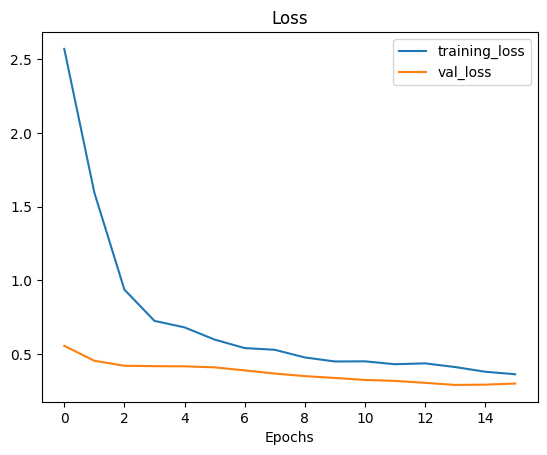

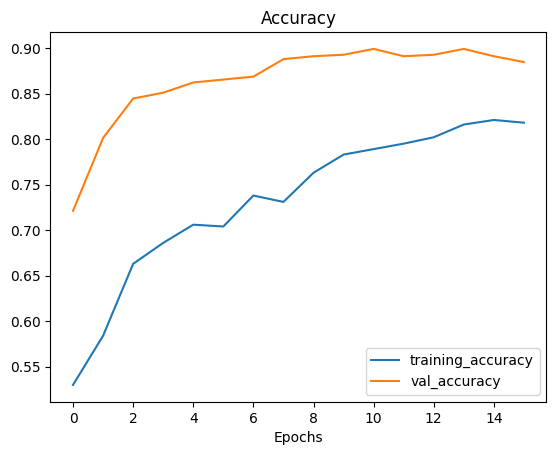

In [12]:
def plot_loss_curves(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(len(history.history['loss']))

    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()


plot_loss_curves(history)

#### Kiíratjuk a legjobb modellnek a pontosságát, amit elmentettünk.

In [18]:
model2 = tf.keras.models.load_model("PheoModel.h5")
print("A modell teszthalmazon vett pontossága:", round(max(history.history['val_accuracy'])*100, 5), "%")

A modell teszthalmazon vett pontossága: 89.90384 %
